<h1>Clean Notebook for QMIND Project</h1>
<p>Contributors:
<ul>
<li>Karim Ali</li>
<li>Ola Elmaghraby</li>
<li>Aimee Langevin</li>
<li>Ali Zidan</li>
</ul>
Project Manager: Frank Siyung Cho</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cv2
import os
import random
from PIL import Image, ImageOps, ImageEnhance
from scipy.ndimage import median_filter

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
K.clear_session()

# Set GPU memory growth to avoid memory allocation issues
#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#if gpu_devices:
#    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Enable mixed-precision training
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

#tf.config.set_per_process_memory_fraction(0.9)
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

<h2>Data Preprocessing</h2>

<p>First we will be displaying initial images in the dataset.<br>Special thanks to Ola who worked tirelessly on preprocessing and cropping images</p>

In [3]:
root = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/new_dataset_images'

In [4]:
#function displays a random image in a given subdirectory
def display_random_image_in_subdir(subdir_path):
    if os.path.isdir(subdir_path):
        all_files = os.listdir(subdir_path)

        jpeg_files = [file for file in all_files if file.lower().endswith(('.jpg'))]

        if jpeg_files: 
            random_jpeg = random.choice(jpeg_files) 
            random_jpeg_path = os.path.join(subdir_path, random_jpeg)

            img = cv2.imread(random_jpeg_path)
        
            if img is not None:
                img_resized = cv2.resize(img, (550,550))
            
                cv2.imshow('Random JPG Image in %s' %subdir_path, img_resized)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
        else:
            print("No JPEG files found in the directory.")

In [5]:
#display_random_image_in_subdir(root)

<p>Capture labels</p>

In [6]:
labels_df = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/new_dataset.csv')

In [7]:
print(labels_df.head())

                                            filename  label
0  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0
1  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0
2  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0
3  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0
4  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0


In [8]:
unique_counts = labels_df['label'].value_counts()
print(unique_counts)

label
0    5404
1    3902
2     579
Name: count, dtype: int64


In [9]:
def print_unique_counts(unique_counts):
    plt.bar('No DR' , unique_counts[0], label= 'No DR')
    plt.bar('Non Proliferative' , unique_counts[1], label = 'Non Proliferative')
    plt.bar('Proliferative' , unique_counts[2], label = 'Proliferative')
    plt.xlabel("Diagnosis")
    plt.ylabel("No. of entries")
    plt.title("Unique Counts")
    plt.show()

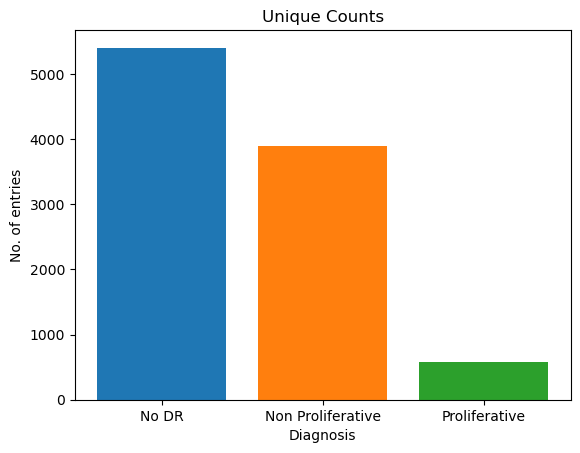

In [10]:
print_unique_counts(unique_counts)

<p>Image Enhancement techniques</p>

In [11]:
#image_files = os.listdir(root)
#x_train = [cv2.cvtColor(cv2.imread(os.path.join(root, file), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for file in image_files]

<p>First we are going to isolate the green channel of the images</p>

In [12]:
def print_channels(x_train):
    idx = 200
    plt.imshow(x_train[idx][:, :, 0], cmap='gray')
    plt.title("red channel")
    plt.show()
    plt.imshow(x_train[idx][:, :, 1], cmap='gray')
    plt.title("green channel")
    plt.show()
    plt.imshow(x_train[idx][:, :, 2], cmap='gray')
    plt.title("blue channel")
    plt.show()

In [13]:
#print_channels(x_train)

In [14]:
#isolate the green channel in every image
#x_train = np.array([x_train[i][:, :, 1] for i in range(len(x_train))])

In [15]:
#save all images in x_train into a new directory called 'enhanced_images' and another called iso_green_channel and convert them to .jpg files
new_dir1 = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/enhanced_images'
new_dir2 = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/iso_green_channel'

#for i in range(len(x_train)):
#    cv2.imwrite(os.path.join(new_dir1, image_files[i]), x_train[i])
#    cv2.imwrite(os.path.join(new_dir2, image_files[i]), x_train[i])

<p>Now we are going to apply a median filter to the enhanced grayscale images</p>

In [16]:
# Apply median filter with a specified filter size
#filtered_array = median_filter(x_train[230][:, :, 1], size=3)

# Convert the filtered array back to an image
#filtered_image = Image.fromarray(filtered_array)

In [17]:
def print_filtered_images(x_train, filtered_array):
    plt.imshow(x_train[230])
    plt.title("3 channels image")
    plt.show()
    plt.imshow(x_train[230][:, :, 1], cmap='gray')
    plt.title("green before median filter")
    plt.show()
    plt.imshow(filtered_array, cmap='gray')
    plt.title("after median filter")
    plt.show()

In [18]:
#print_filtered_images(x_train, filtered_array)

In [19]:
#apply median filter to all images
def apply_median_filter(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg"):  
            img_path = os.path.join(input_dir, filename)
            img = cv2.imread(img_path)

            # Convert BGR to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Apply median filter
            filtered_img = median_filter(img_rgb, size=3)

            # Convert RGB to BGR for saving
            filtered_img_bgr = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2BGR)

            # Save filtered image
            cv2.imwrite(os.path.join(output_dir, filename), filtered_img_bgr)

In [20]:
output_dir = "C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/enhanced_med_clahe_images"
#save all images in x_train into a new directory called 'median_filter_images' and convert them to .jpg files
#apply_median_filter(root, output_dir)

<p>We are now going to apply a Contrast Limited Adaptive Histogram to the images</p>

In [21]:
def enhance_luminance(image, gamma=1/2.2):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv_image[:, :, 2]
    normalized_v = v_channel / 255.0
    gamma_corrected_v = np.power(normalized_v, gamma)
    enhanced_v = (gamma_corrected_v * 255.0).astype(np.uint8)
    hsv_image[:, :, 2] = enhanced_v
    enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return enhanced_image

In [22]:
def enhance_contrast(image, gamma=1/2.2, clip_limit=3, tiles=(4, 4)):
    enhanced_image = enhance_luminance(image, gamma)
    lab_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2Lab)
    l_channel = lab_image[:, :, 0]
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tiles)
    enhanced_l_channel = clahe.apply(l_channel)
    lab_image[:, :, 0] = enhanced_l_channel
    enhanced_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2BGR)
    return enhanced_image

In [23]:
def process_images(directory, final_directory):
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path)
        enhanced_contrast_image = enhance_contrast(image)
        cv2.imwrite(os.path.join(final_directory, filename), enhanced_contrast_image)

In [24]:
CLAHE_dir = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/CLAHE_images'
input_dir = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/median_filter_images'
#process_images(input_dir, output_dir)

<p>Work on finalized labels</p>

In [25]:
#Reformat the labels for enhanced images
#df = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/new_dataset.csv', header=None)

#df[0] = df[0].str.replace('new_dataset_images', 'enhanced_images')
#df.to_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/enhanced_dataset.csv', index=False, header=False)

In [26]:
#Create a combined csv file which combines the contents of the original csv file and the enhanced csv file
#df1 = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/new_dataset.csv', header=None)
#df2 = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/enhanced_dataset.csv', header=None)

#df3 = pd.concat([df1, df2])

#add column names to the combined csv file 
#df3.columns = ['filename', 'label']
#df3.to_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/combined_dataset.csv', index=False)

In [27]:
labels_df = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/balanced_new_dataset_and_enhanced_med_clahe.csv')

In [28]:
unique_counts = labels_df['label'].value_counts()
print(unique_counts)

label
0    1158
1    1158
2    1158
Name: count, dtype: int64


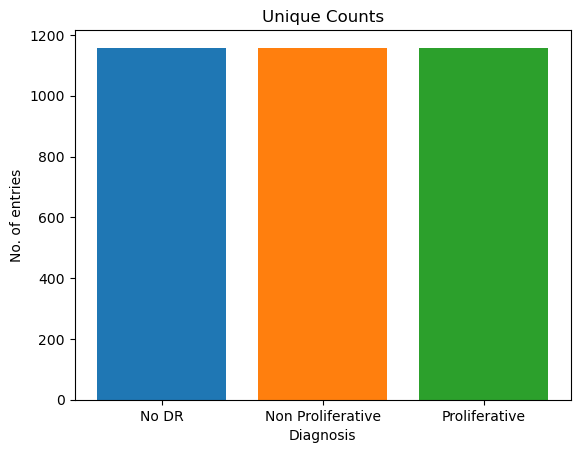

In [29]:
print_unique_counts(unique_counts)

<p>Image Augmentation techniques</p>

In [30]:
train_df, temp_df = train_test_split(labels_df, test_size=0.3, random_state=42)

In [31]:
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, x_col="filename", y_col="label", color_mode="rgb", class_mode="raw", batch_size=50)
validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df, x_col="filename", y_col="label", color_mode="rgb", class_mode="raw", batch_size=50)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, x_col="filename", y_col="label", color_mode="rgb", class_mode="raw", batch_size=50)

Found 2431 validated image filenames.
Found 521 validated image filenames.
Found 522 validated image filenames.


In [34]:
total_train_images = train_generator.n
print(f"Total number of training images: {total_train_images}")

total_validation_images = validation_generator.n
print(f"Total number of validation images: {total_validation_images}")

total_test_images = test_generator.n
print(f"Total number of test images: {total_test_images}")

Total number of training images: 2431
Total number of validation images: 521
Total number of test images: 522


In [35]:
for i, (images, labels) in enumerate(train_generator):
    print(f"Batch {i}, Image batch shape: {images.shape}, Labels batch shape: {labels.shape}")
    if i == 1: 
        break

Batch 0, Image batch shape: (50, 256, 256, 3), Labels batch shape: (50,)
Batch 1, Image batch shape: (50, 256, 256, 3), Labels batch shape: (50,)


50


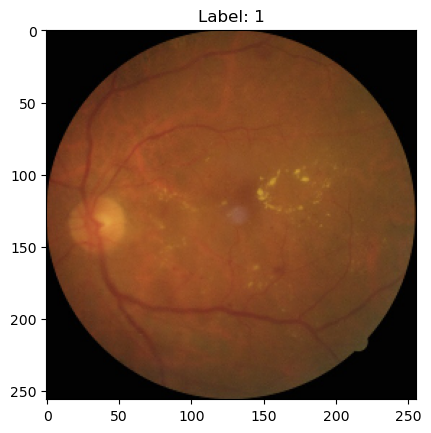

In [36]:
images, labels = next(train_generator)
print(len(images))

for i in range(1): 
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()

In [37]:
# Initialize lists to store the images and labels
train_images = []
train_labels = []

# Iterate over the generator
for img_batch, label_batch in train_generator:
    train_images.extend(img_batch)
    train_labels.extend(label_batch)
    
    # Break the loop once we've gone through all the data
    if train_generator.batch_index == 0:
        break

# Convert the lists to numpy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)

In [38]:
# Initialize lists to store the images and labels
test_images = []
test_labels = []

# Iterate over the generator
for img_batch, label_batch in test_generator:
    test_images.extend(img_batch)
    test_labels.extend(label_batch)
    
    # Break the loop once we've gone through all the data
    if test_generator.batch_index == 0:
        break

# Convert the lists to numpy arrays
X_test = np.array(test_images)
y_test = np.array(test_labels)

In [39]:
# Initialize lists to store the images and labels
valid_images = []
valid_labels = []

# Iterate over the generator
for img_batch, label_batch in validation_generator:
    valid_images.extend(img_batch)
    valid_labels.extend(label_batch)
    
    # Break the loop once we've gone through all the data
    if validation_generator.batch_index == 0:
        break

# Convert the lists to numpy arrays
X_valid = np.array(valid_images)
y_valid = np.array(valid_labels)

In [40]:
# Adjust the create_model function to use ResNet50
def create_model_resnet50(optimizer='adam'):
    # Load the ResNet50 model, pre-trained weights, without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))    

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
def create_model_inceptionV3(optimizer='adam'):
    # Load the InceptionV3 model, pre-trained weights, without the top layer
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))    

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [42]:
#using Train_IMG_Set and validation_IMG_Set create a model that can classify the images into the 3 classes
def create_model(optimizer='adam'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [43]:
#model = KerasClassifier(model=create_model_inceptionV3, verbose=1) 

# define the grid search parameters
#param_grid = {'batch_size': [32, 64],
#              'epochs': [25, 30, 35],
#              'optimizer': ['SGD', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=3)
#grid_result = grid.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Epoch 1/25
48/48 [==============================] - 24s 461ms/step - loss: 1.2153 - accuracy: 0.5257 - val_loss: 0.7416 - val_accuracy: 0.6679
Epoch 2/25
48/48 [==============================] - 21s 439ms/step - loss: 0.9082 - accuracy: 0.5908 - val_loss: 0.7187 - val_accuracy: 0.6718
Epoch 3/25
48/48 [==============================] - 21s 438ms/step - loss: 0.8327 - accuracy: 0.6105 - val_loss: 0.7165 - val_accuracy: 0.6871
Epoch 4/25
48/48 [==============================] - 21s 435ms/step - loss: 0.7636 - accuracy: 0.6434 - val_loss: 0.7394 - val_accuracy: 0.6564
Epoch 5/25
48/48 [==============================] - 21s 437ms/step - loss: 0.7263 - accuracy: 0.6664 - val_loss: 0.6848 - val_accuracy: 0.6948
Epoch 6/25
48/48 [==============================] - 21s 435ms/step - loss: 0.6982 - accuracy: 0.6599 - val_loss: 0.6780 - val_accuracy: 0.7063
Epoch 7/25
48/48 [==============================] - 21s 432ms/step - loss: 0.704

In [44]:
#folder_top_level = 'Aimee'
#dir_name = 'A2'

Epoch 1/35
36/36 [==============================] - 63s 2s/step - loss: 1.4986 - accuracy: 0.4327 - val_loss: 1.1661 - val_accuracy: 0.3148
Epoch 2/35
36/36 [==============================] - 56s 2s/step - loss: 0.9997 - accuracy: 0.5182 - val_loss: 1.3344 - val_accuracy: 0.3148
Epoch 3/35
36/36 [==============================] - 55s 2s/step - loss: 0.9068 - accuracy: 0.5633 - val_loss: 1.5246 - val_accuracy: 0.3148
Epoch 4/35
36/36 [==============================] - 55s 2s/step - loss: 0.8540 - accuracy: 0.5940 - val_loss: 1.5588 - val_accuracy: 0.3148
Epoch 5/35
36/36 [==============================] - 55s 2s/step - loss: 0.7916 - accuracy: 0.6243 - val_loss: 1.6009 - val_accuracy: 0.3148
Epoch 6/35
36/36 [==============================] - 54s 2s/step - loss: 0.7401 - accuracy: 0.6633 - val_loss: 1.6082 - val_accuracy: 0.3167
Epoch 7/35
36/36 [==============================] - 55s 2s/step - loss: 0.6923 - accuracy: 0.6795 - val_loss: 1.4786 - val_accuracy: 0.3282
Epoch 8/35
36/36 [==

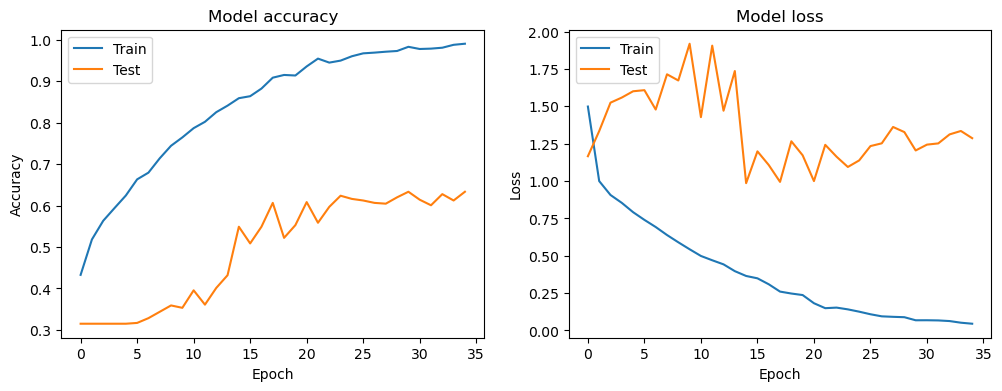

In [45]:
# Get the best parameters
#best_params = grid_result.best_params_

# Create the model with the best parameters
#best_model = create_model(optimizer=best_params['optimizer'])

# Fit the model and save the history
#history = best_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=best_params['epochs'], batch_size=best_params['batch_size'])

# Plot the training & validation accuracy values
#plt.figure(figsize=(12, 4))

#plt.subplot(1, 2, 1)
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')

# Plot the training & validation loss values
#plt.subplot(1, 2, 2)
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/Test_results/{folder_top_name}/{folder_name}/graph.png'.format(folder_name = dir_name, folder_top_name = folder_top_level))

#plt.show()

#best_model.save('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/Test_results/{folder_top_name}/{folder_name}/{folder_name}.keras'.format(folder_name = dir_name, folder_top_name = folder_top_level))

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/Test_results/Aimee/A3/A3.keras')

17/17 [==============================] - 2s 140ms/step
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       192
           1       0.59      0.55      0.57       162
           2       0.75      0.74      0.74       168

    accuracy                           0.69       522
   macro avg       0.68      0.68      0.68       522
weighted avg       0.69      0.69      0.69       522



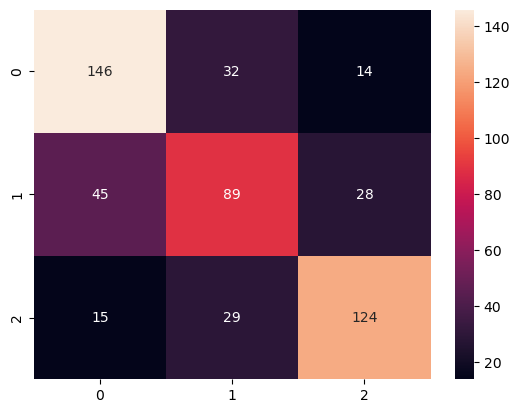

In [46]:
# Get the model's predictions on the test data
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class labels

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
#plt.savefig('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/Test_results/{folder_top_name}/{folder_name}/confusion.png'.format(folder_name = dir_name, folder_top_name = folder_top_level))

# Print the classification report
report = classification_report(y_test, y_pred_classes)
print(report)